# **Generating Synthetic Credit Card Transaction Data using Variational Autoencoder**

**This is the list of our group members:**

1. Vadapalli Sai Sravan (CS24MTECH02007)
2. Supreet Shukla (CS24MTECH02004)
3. Tarun Jangir (CS24MTECH02005)
4. Taufique Ramzan Shaikh (CS24MTECH02006)
5. Afzaal Ahmad (CS24MTECH02002)

# **Training the Variational Auto Encoder model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split

#Load the dataset
data_original = pd.read_csv("/content/drive/MyDrive/card_transaction.v1.csv")

data = data_original

#Remove '$' symbol from 'Amount' column and convert to float
data['Amount'] = data['Amount'].str.replace('$', '').astype(float)

data['Errors?'].fillna("No Error", inplace=True)

#Handle empty values
data.fillna(data.mode().iloc[0], inplace=True)

#Label encode categorical columns and normalize all columns
label_encoders = {}
for column in data.columns:
    if column != 'Amount':
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

#Train a Variational Autoencoder (VAE)
latent_dim = 5
input_dim = data_scaled.shape[1]

encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(12, activation='relu')(encoder_inputs)
x = layers.Dense(latent_dim, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(latent_dim, activation='relu')(decoder_latent_inputs)
x = layers.Dense(12, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = tf.keras.Model(decoder_latent_inputs, decoder_outputs, name='decoder')
vae = tf.keras.Model(encoder_inputs, decoder(encoder(encoder_inputs)[2]), name='vae')

vae.compile(optimizer='adam', loss='binary_crossentropy')
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)
vae.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, X_test))


# Generate the same number of samples as in data_scaled
num_samples = data_scaled.shape[0]
z_mean, z_log_var, _ = encoder.predict(data_scaled)
epsilon = np.random.normal(size=(num_samples, latent_dim))
z_sample = z_mean + np.exp(0.5 * z_log_var) * epsilon
synthetic_data_scaled = decoder.predict(z_sample)
synthetic_data = scaler.inverse_transform(synthetic_data_scaled)



Epoch 1/50
63880/63880 [==============================] - 210s 3ms/step - loss: 0.4666 - val_loss: 0.4616
Epoch 2/50
63880/63880 [==============================] - 220s 3ms/step - loss: 0.4613 - val_loss: 0.4609
Epoch 3/50
63880/63880 [==============================] - 225s 4ms/step - loss: 0.4594 - val_loss: 0.4498
Epoch 4/50
63880/63880 [==============================] - 199s 3ms/step - loss: 0.4490 - val_loss: 0.4481
Epoch 5/50
63880/63880 [==============================] - 210s 3ms/step - loss: 0.4481 - val_loss: 0.4480
Epoch 6/50
63880/63880 [==============================] - 241s 4ms/step - loss: 0.4479 - val_loss: 0.4480
Epoch 7/50
63880/63880 [==============================] - 242s 4ms/step - loss: 0.4479 - val_loss: 0.4477
Epoch 8/50
63880/63880 [==============================] - 264s 4ms/step - loss: 0.4477 - val_loss: 0.4474
Epoch 9/50
63880/63880 [==============================] - 255s 4ms/step - loss: 0.4476 - val_loss: 0.4477
Epoch 10/50
63880/63880 [=====================

# **Evaluating the model and calculating MSE**

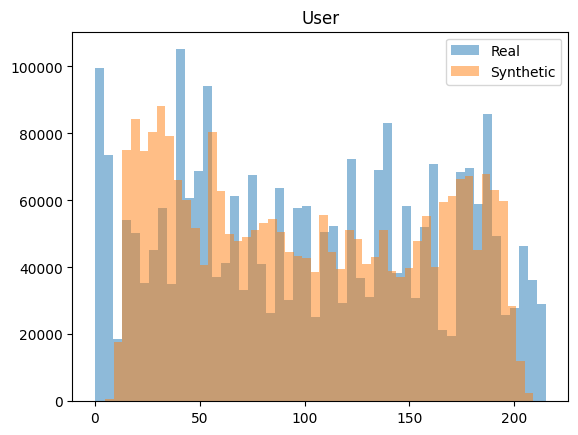

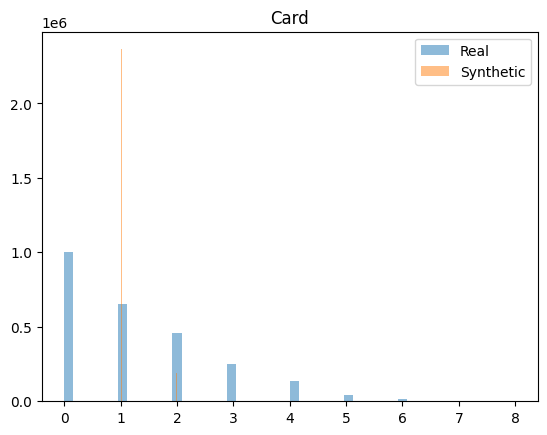

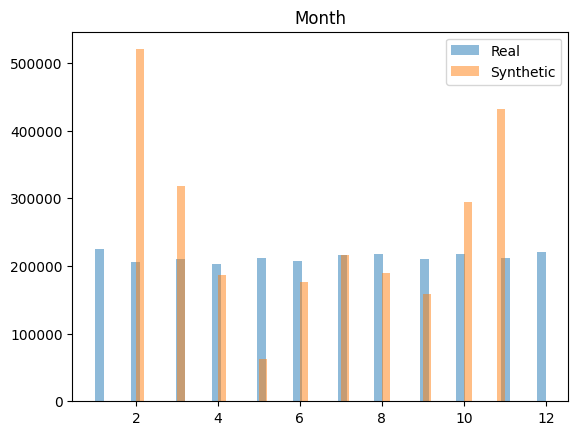

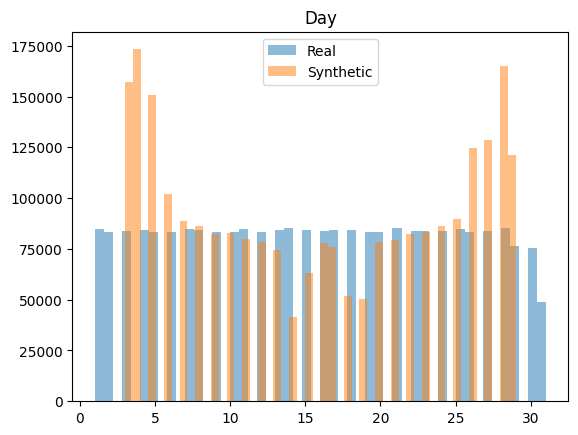

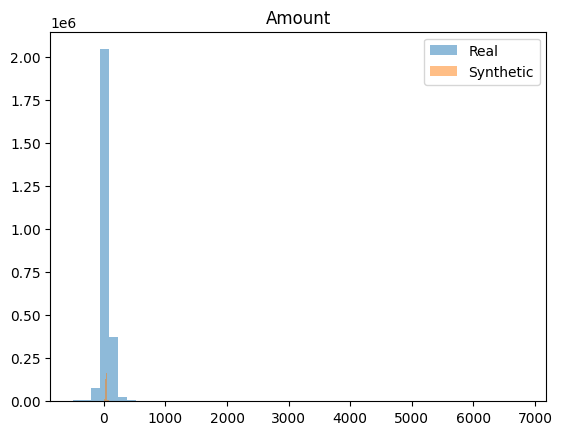

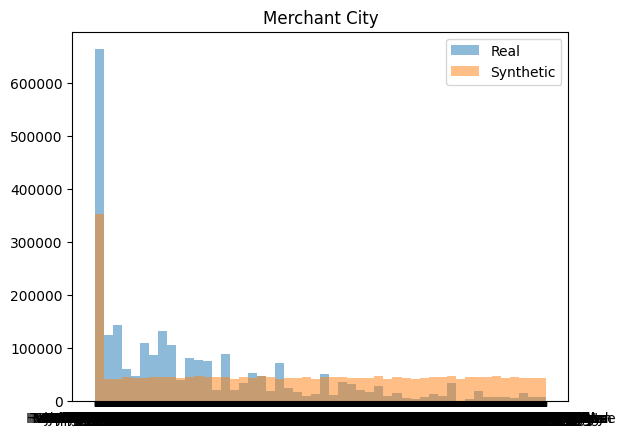

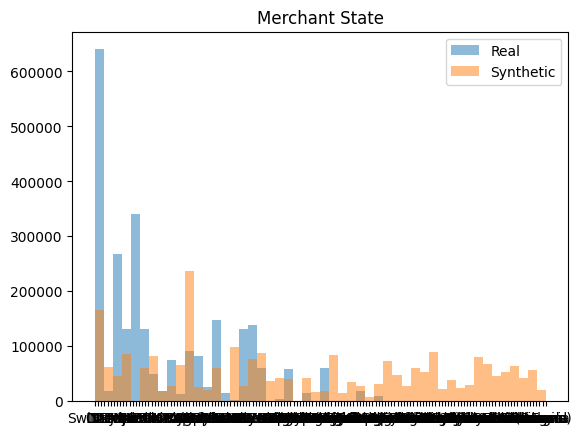

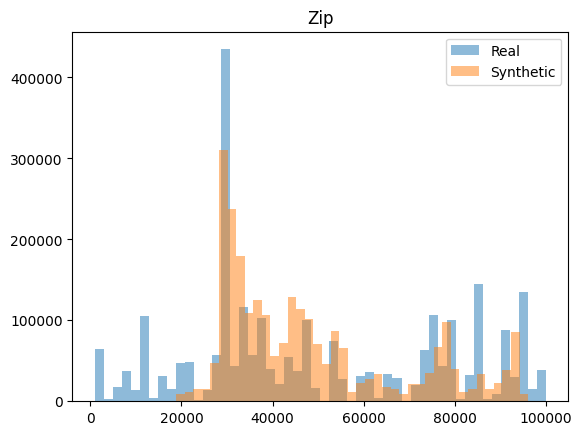

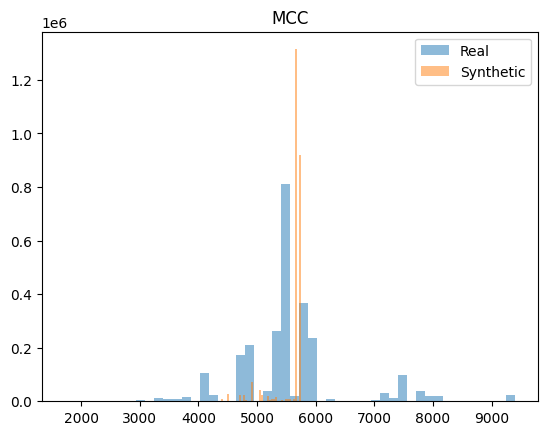

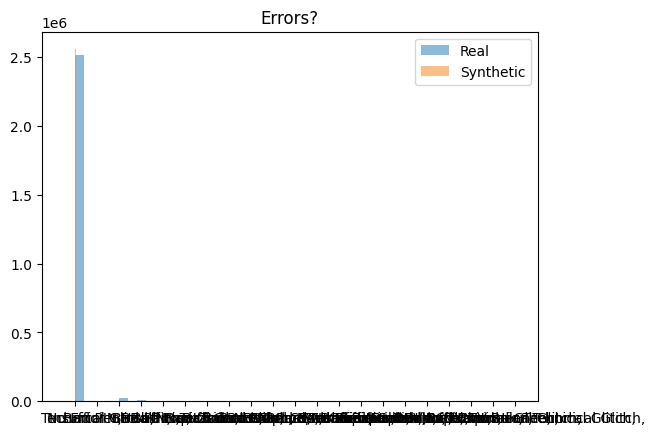

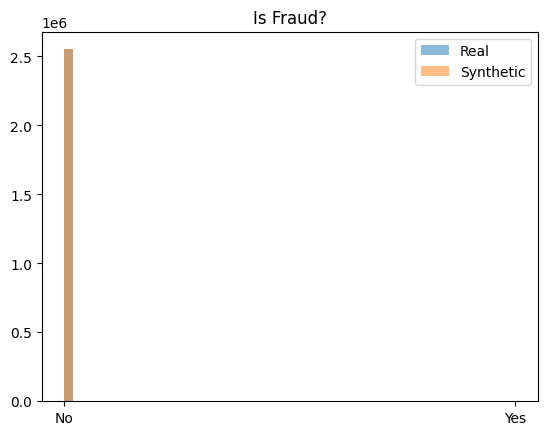

Mean Squared Error: 0.017480621417907793


In [ ]:
#Evaluate the model
import matplotlib.pyplot as plt

fig_size = (20, 10)

for column in data.columns:
    if column != 'Amount':
        real_values = label_encoders[column].inverse_transform(data[column])
        synthetic_values = label_encoders[column].inverse_transform(np.round(synthetic_data[:, data.columns.get_loc(column)]).astype(int))
    else:
        real_values = data[column]
        synthetic_values = synthetic_data[:, data.columns.get_loc(column)]

    plt.figure()
    plt.hist(real_values, bins=50, alpha=0.5, label='Real')
    plt.hist(synthetic_values, bins=50, alpha=0.5, label='Synthetic')
    plt.legend()
    plt.title(column)
    plt.show()

# Calculate mean squared error
mse = np.mean(np.square(data_scaled - synthetic_data_scaled))
print("Mean Squared Error:", mse)

# **SUMMARY**


**Introduction**:
This code uses a Variational Autoencoder (VAE) for generating synthetic credit card transaction data. The VAE is a deep learning model that learns to compress and reconstruct data, allowing for the generation of new synthetic samples that resemble the original data distribution.

**Data Preprocessing**:
The credit card transaction dataset is loaded from a CSV file and undergoes several preprocessing steps. These steps include removing unwanted symbols, handling missing values, label encoding categorical columns, and normalizing all columns using the MinMaxScaler from scikit-learn. The preprocessing ensures that the data is in a suitable format for training the VAE model.

**VAE Model Architecture**:
The VAE model consists of an encoder and a decoder. The encoder takes the input data and maps it to a lower-dimensional latent space, capturing the essential features of the data. The decoder then reconstructs the original data from the latent space representation. The architecture of the VAE is defined using the Keras library, specifying the number of layers, activation functions, and latent space dimensions.

**Model Training**:
The preprocessed data is split into training and testing sets using the train_test_split function from scikit-learn. The VAE model is compiled with the Adam optimizer and binary cross-entropy loss. It is then trained on the training data for 50 epochs with a batch size of 32. The model's performance is validated on the testing data to ensure its generalization ability.

**Synthetic Data Generation**:
After training, the VAE model is used to generate synthetic credit card transaction data. The trained encoder is employed to map the original data to the latent space, and then random samples are drawn from the latent space. These samples are passed through the trained decoder to generate synthetic data samples that resemble the original data distribution.

**Results and Evaluation**:
The quality of the generated synthetic data of 2 million transactions is evaluated using both visual and quantitative metrics. **Histograms are plotted to compare the distributions of real and synthetic data for each column, providing a visual assessment of the similarity between the two. There are 15 histograms that are plotted. Please scroll down in the output section of the second cell to see all the histograms.**
Additionally, the mean squared error (MSE) between the original and reconstructed data is calculated as a quantitative measure of the VAE's reconstruction ability and its value turned out to be **0.017480621417907793**. The MSE value is printed at the bottom of the output section of the second cell after all the histograms.

